# Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей
6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [1]:
# Импартируем необходимые для работы библиотеки:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import TwoModels

import random
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

Работать будем с данными об удержании клиентов, для прогнозирования оттока или моделирование прироста.

У нас есть маркетинговая кампания с данными о 6400 клиентах.

В нашем df есть следующие столбцы:
 
1) recency (новизна) - кол-во месяцев с момента последней покупки. 
2) history - история покупок  
3) used_discount - есть ли у клиента скидка
4) used_bogo - использовал ли клиент функцию «купить, получить, прежде чем»   
5) zip_code - почтовый индекс пригородный / городской / сельский 
6) is_referral -  был ли клиент привлечен по реферальному каналу (по рекомендации)   
7) channel - каналы, которые использует клиент(Телефон/Интернет/Многоканальный )      
8) offer - предложения, отправленные клиентам       
9) conversion - результат конверсии клиентов (купит или нет)

*Средняя ценность конверсии = 25 долларов США.

In [2]:
df = pd.read_csv('C:/Users/User/Desktop/Машинное обучение в бизнесе/4/HW4/data.csv')

In [3]:
# Посмотрим информацию по нашему df:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


На первый взгляд в df отсутствуют пропуски, но это может быть не совсем так, там может быть 0 или 'нет', что не является nan, но и информации нам не даст.

In [4]:
# Посмотрим количественные показатели нашего df
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


И посмотрим на наши objects:

In [5]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

zip_code

zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64
****************************************************************************************************

channel

channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64
****************************************************************************************************

offer

offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64
****************************************************************************************************



Мы видим, что в некоторых признаках у нас присутствует явный дисбаланс классов, в идеале его нужно обработать чтобы получить более точные прогнозы/предсказания. Так как конечная цель этой работы провести uplift-моделирование, то мы опустим моменты с проверкой данных на выбросы, некорректность, пропуски, балансы и т.д. Возьмем на веру, что у нас уже чистые данные и мы можем с ними работать. 

Перейдем к выполнению домашнего задания:

Первый пункт мы выполнили.)

Второй пункт у нас :

поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

**Приступим:** 

In [6]:
#переименуем поля:
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True )

In [7]:
# Проверим что замена прошла успешно:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Далее нам надо привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
Так как у нас довольно облегченная задача, то и придумывать "велосипед" я не вижу смысла, будем использовать самый легкий и банальный способ:

In [8]:
df['treatment'] = df['treatment'].replace(['No Offer','Buy One Get One','Discount'],[0, 1, 1])
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
5,6,134.83,0,1,Surburban,0,Phone,1,1
6,9,280.20,1,0,Surburban,1,Phone,1,0
7,9,46.42,0,1,Urban,0,Phone,1,0
8,9,675.07,1,1,Rural,1,Phone,1,0
9,10,32.84,0,1,Urban,1,Web,1,0


Пункт три, сделать разбиение набора данных не тренировочную и тестовую выборки:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), 
                                                    df['target'], random_state=15)

Пункт 4,провести uplift-моделирование 3 способами:

    Одна модель с признаком коммуникации (S-learner)
    Модель с трансформацией таргета
    Вариант с двумя независимыми моделями

Одна модель с признаком коммуникации (S-learner):

In [10]:
train_treatment = X_train['treatment']
X_train = X_train.drop('treatment', axis=1)

test_treatment = X_test['treatment']
X_test = X_test.drop('treatment', axis=1)

In [11]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

cat_features = ['zip_code', 'channel']

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

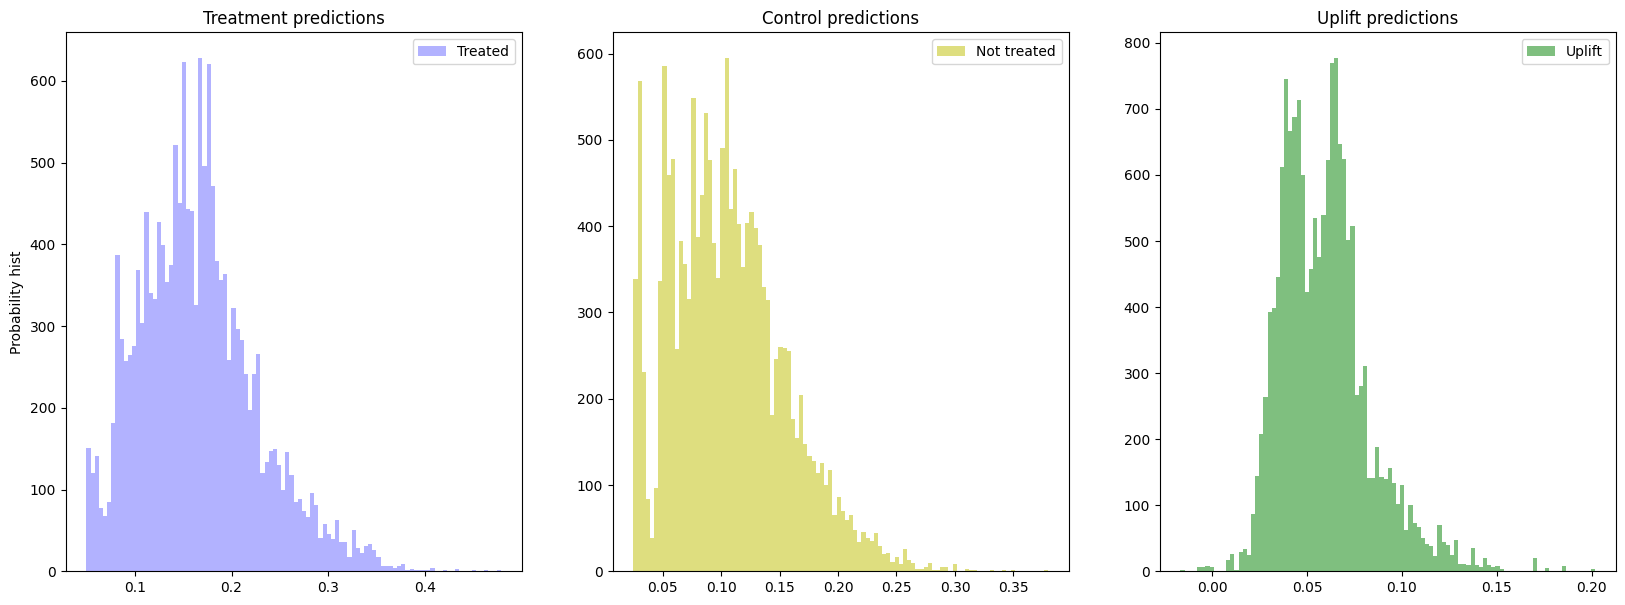

In [12]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, train_treatment)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.2)


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

Модель с трансформацией таргета:

In [13]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, train_treatment)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=test_treatment, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=test_treatment, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

Две независимые модели:

In [14]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, train_treatment
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=test_treatment, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=test_treatment, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

5 пункт, вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [15]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.104983,0.087097
1,ClassTransformation,0.099690,0.073972
0,SoloModel,0.088021,0.088949
